**`Split Delivery Vehicle Routing Problem`**

In [ ]:
pip install scipy

In [ ]:
pip install PuLP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 64.5 MB/s eta 0:00:00


In [ ]:
pip install pulp

In [ ]:
from pulp import LpVariable, LpProblem, lpSum, LpMinimize, LpBinary
import numpy as np
num_customers = 10
num_vehicles = 3
vehicle_capacities = [100, 150, 120]
customer_demands = [20, 30, 15, 25, 10, 35, 40, 50, 30, 45]
distance_matrix = np.array([
    [0, 10, 15, 25, 18, 30, 22, 17, 25, 20],
    [10, 0, 12, 22, 20, 28, 20, 15, 22, 30],
    [15, 12, 0, 18, 25, 15, 30, 22, 10, 28],
    [25, 22, 18, 0, 35, 10, 40, 32, 25, 15],
    [18, 20, 25, 35, 0, 30, 12, 27, 35, 40],
    [30, 28, 15, 10, 30, 0, 25, 17, 22, 10],
    [22, 20, 30, 40, 12, 25, 0, 12, 18, 30],
    [17, 15, 22, 32, 27, 17, 12, 0, 18, 25],
    [25, 22, 10, 25, 35, 22, 18, 18, 0, 15],
    [20, 30, 28, 15, 40, 10, 30, 25, 15, 0]
])
x = LpVariable.dicts("x", ((i, j, k) for i in range(num_customers) for j in range(num_customers) for k in range(num_vehicles)), 0, 1, LpBinary)
prob = LpProblem("SDVRP", LpMinimize)
prob += lpSum(distance_matrix[i][j] * x[i, j, k] for i in range(num_customers) for j in range(num_customers) for k in range(num_vehicles)), "Total Distance"
for i in range(num_customers):
    prob += lpSum(x[i, j, k] for j in range(num_customers) for k in range(num_vehicles)) == 1, f"Visit_Customer_{i}"
for k in range(num_vehicles):
    prob += lpSum(x[0, j, k] for j in range(1, num_customers)) == 1, f"Leave_Depot_Vehicle_{k}"
    prob += lpSum(x[i, 0, k] for i in range(1, num_customers)) == 1, f"Return_Depot_Vehicle_{k}"
for k in range(num_vehicles):
    prob += lpSum(customer_demands[i] * x[i, j, k] for i in range(num_customers) for j in range(num_customers)) <= vehicle_capacities[k], f"Capacity_Vehicle_{k}"
prob.solve()
print("Optimal Solution:-")
for k in range(num_vehicles):
    route = [i for j in range(num_customers) for i in range(num_customers) if x[i, j, k].varValue == 1]
    print(f"Vehicle {k + 1}: Depot -> {' -> '.join([f'Customer {c + 1} ({customer_demands[c]} units)' for c in route])} -> Depot")
print("Total Distance =", prob.objective.value())

Optimal Solution:-
Vehicle 1: Depot -> Customer 2 (30 units) -> Customer 1 (20 units) -> Customer 4 (25 units) -> Customer 9 (30 units) -> Depot
Vehicle 2: Depot -> Customer 3 (15 units) -> Customer 1 (20 units) -> Customer 8 (50 units) -> Depot
Vehicle 3: Depot -> Customer 3 (15 units) -> Customer 1 (20 units) -> Customer 6 (35 units) -> Customer 7 (40 units) -> Customer 10 (45 units) -> Depot
Total Distance = 70.0


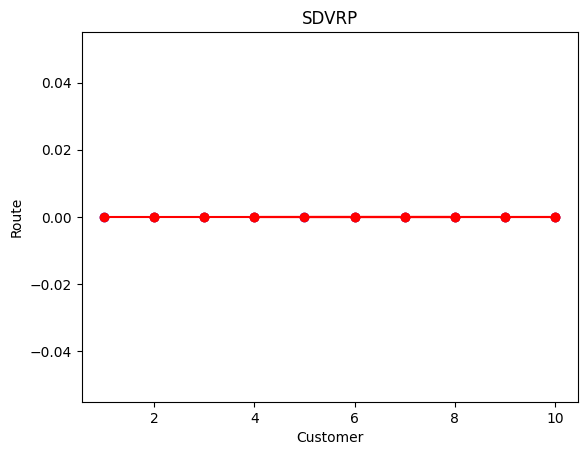

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
num_customers = 10
num_vehicles = 3
alpha = 1.0
beta = 2.0
rho = 0.5
Q = 1.0
num_ants = 10
num_iterations = 100
distance_matrix = np.array([
    [0, 10, 15, 25, 18, 30, 22, 17, 25, 20],
    [10, 0, 12, 22, 20, 28, 20, 15, 22, 30],
    [15, 12, 0, 18, 25, 15, 30, 22, 10, 28],
    [25, 22, 18, 0, 35, 10, 40, 32, 25, 15],
    [18, 20, 25, 35, 0, 30, 12, 27, 35, 40],
    [30, 28, 15, 10, 30, 0, 25, 17, 22, 10],
    [22, 20, 30, 40, 12, 25, 0, 12, 18, 30],
    [17, 15, 22, 32, 27, 17, 12, 0, 18, 25],
    [25, 22, 10, 25, 35, 22, 18, 18, 0, 15],
    [20, 30, 28, 15, 40, 10, 30, 25, 15, 0]
])
pheromone_matrix = np.ones((num_customers, num_customers)) / 10.0
for iteration in range(num_iterations):
    ant_tours = []
    ant_distances = []
    for ant in range(num_ants):
        current_node = 0
        unvisited_nodes = set(range(1, num_customers))
        tour = [current_node]
        total_distance = 0
        while unvisited_nodes:
            probabilities = []
            for neighbor in unvisited_nodes:
                pheromone = pheromone_matrix[current_node, neighbor]
                distance = distance_matrix[current_node, neighbor]
                probability = (pheromone ** alpha) * ((1.0 / distance) ** beta)
                probabilities.append((neighbor, probability))
            probabilities = np.array(probabilities)
            probabilities[:, 1] /= probabilities[:, 1].sum()
            next_node = int(np.random.choice(probabilities[:, 0], p=probabilities[:, 1]))
            tour.append(next_node)
            total_distance += distance_matrix[current_node, next_node]
            current_node = next_node
            unvisited_nodes.remove(current_node)
        ant_tours.append(tour)
        ant_distances.append(total_distance)
    delta_pheromone = np.zeros((num_customers, num_customers))
    for i in range(num_ants):
        for j in range(len(ant_tours[i]) - 1):
            delta_pheromone[ant_tours[i][j], ant_tours[i][j + 1]] += Q / ant_distances[i]
    pheromone_matrix = (1.0 - rho) * pheromone_matrix + delta_pheromone
best_ant_index = np.argmin(ant_distances)
best_tour = ant_tours[best_ant_index]
best_distance = ant_distances[best_ant_index]
fig, ax = plt.subplots()

for i in range(num_customers):
    ax.plot(i + 1, 0, 'bo')
for i in range(len(best_tour) - 1):
    start_customer = best_tour[i] + 1
    end_customer = best_tour[i + 1] + 1
    ax.plot([start_customer, end_customer], [0, 0], marker='o', color='red')
ax.set_xlabel('Customer')
ax.set_ylabel('Route')
ax.set_title('SDVRP')
plt.show()

**`Stochastic Vehicle Routing Problem`**

In [ ]:
import numpy as np
import random
class StochasticVRP:
    def __init__(self, num_locations, num_vehicles, max_capacity, distance_matrix, demand, travel_time_mean, travel_time_std):
        self.num_locations = num_locations
        self.num_vehicles = num_vehicles
        self.max_capacity = max_capacity
        self.distance_matrix = distance_matrix
        self.demand = demand
        self.travel_time_mean = travel_time_mean
        self.travel_time_std = travel_time_std
    def generate_initial_solution(self):
        solution = []
        for vehicle in range(self.num_vehicles):
            route = [0]
            capacity_used = 0
            while capacity_used < self.max_capacity:
                next_location = random.randint(1, self.num_locations - 1)
                if next_location not in route:
                    route.append(next_location)
                    capacity_used += self.demand[next_location]
            solution.append(route)
        return solution
    def evaluate_solution(self, solution):
        total_travel_time = 0
        for route in solution:
            for i in range(len(route) - 1):
                from_location = route[i]
                to_location = route[i + 1]
                travel_time = max(np.random.normal(self.travel_time_mean, self.travel_time_std), 0)
                total_travel_time += travel_time
        return total_travel_time
    def ant_colony_optimization(self, num_iterations, num_ants, alpha, beta, evaporation_rate):
        best_solution = None
        best_travel_time = float('inf')
        for iteration in range(num_iterations):
            ants = [self.generate_ant_solution() for _ in range(num_ants)]
            for ant_solution in ants:
                travel_time = self.evaluate_solution(ant_solution)
                if travel_time < best_travel_time:
                    best_solution = ant_solution
                    best_travel_time = travel_time
            self.update_pheromones(ants, best_solution, evaporation_rate)
        return best_solution, best_travel_time
    def generate_ant_solution(self):
        solution = []
        for vehicle in range(self.num_vehicles):
            route = [0]
            capacity_used = 0
            while capacity_used < self.max_capacity:
                probabilities = self.calculate_probabilities(route)
                next_location = self.select_next_location(probabilities)
                if next_location not in route:
                    route.append(next_location)
                    capacity_used += self.demand[next_location]
            solution.append(route)
        return solution
    def calculate_probabilities(self, route):
        probabilities = []
        last_location = route[-1]
        pheromones = self.distance_matrix[last_location]
        for location in range(self.num_locations):
            if location not in route:
                probability = (pheromones[location] ** alpha) * ((1 / self.distance_matrix[last_location][location]) ** beta)
                probabilities.append(probability)
            else:
                probabilities.append(0)
        total_probability = sum(probabilities)
        probabilities = [p / total_probability for p in probabilities]
        return probabilities
    def select_next_location(self, probabilities):
        rand = random.random()
        cumulative_prob = 0
        for i, prob in enumerate(probabilities):
            cumulative_prob += prob
            if rand <= cumulative_prob:
                return i
    def update_pheromones(self, ants, best_solution, evaporation_rate):
        self.distance_matrix *= (1 - evaporation_rate)
        for route in best_solution:
            for i in range(len(route) - 1):
                from_location = route[i]
                to_location = route[i + 1]
                self.distance_matrix[from_location][to_location] += 1 / self.evaluate_solution(best_solution)
        for ant_solution in ants:
            for route in ant_solution:
                for i in range(len(route) - 1):
                    from_location = route[i]
                    to_location = route[i + 1]
                    self.distance_matrix[from_location][to_location] += 1 / self.evaluate_solution(ant_solution)
num_locations = 5
num_vehicles = 2
max_capacity = 20
distance_matrix = np.array([[0, 10, 15, 20, 25],
                            [10, 0, 10, 15, 20],
                            [15, 10, 0, 10, 15],
                            [20, 15, 10, 0, 10],
                            [25, 20, 15, 10, 0]], dtype=float)
demand = [0, 5, 10, 15, 8]
travel_time_mean = 10
travel_time_std = 2
num_iterations = 100
num_ants = 10
alpha = 1.0
beta = 2.0
evaporation_rate = 0.1
svrp_instance = StochasticVRP(num_locations, num_vehicles, max_capacity, distance_matrix, demand, travel_time_mean, travel_time_std)
best_solution, best_travel_time = svrp_instance.ant_colony_optimization(num_iterations, num_ants, alpha, beta, evaporation_rate)
print("Best Solution =", best_solution)
print("Best Travel Time =", best_travel_time)

Best Solution = [[0, 2, 3], [0, 1, 3]]
Best Travel Time = 29.836159005355604


Imagine a delivery service company that uses a fleet of vehicles to deliver packages to various customers. The challenge is that the travel times between locations are uncertain due to factors such as traffic conditions.

Number of Locations: 10 (including the depot)

Number of Vehicles: 3

Maximum Vehicle Capacity: 100 units

Demand at Each Customer Location: [0, 20, 30, 10, 15, 25, 35, 10, 5, 20]

Travel Times (in minutes) Matrix: A symmetric matrix with uncertain travel times, sampled from a normal distribution with mean 15 minutes and standard deviation 5 minutes.

In [ ]:
import numpy as np
import random
class StochasticVRP:
    def __init__(self, num_locations, num_vehicles, max_capacity, demand, travel_time_mean, travel_time_std):
        self.num_locations = num_locations
        self.num_vehicles = num_vehicles
        self.max_capacity = max_capacity
        self.demand = demand
        self.travel_time_mean = travel_time_mean
        self.travel_time_std = travel_time_std
        self.distance_matrix = self.generate_distance_matrix()
    def generate_distance_matrix(self):
        distance_matrix = np.zeros((self.num_locations, self.num_locations))
        for i in range(1, self.num_locations):
            for j in range(i + 1, self.num_locations):
                travel_time = max(np.random.normal(self.travel_time_mean, self.travel_time_std), 0)
                distance_matrix[i][j] = travel_time
                distance_matrix[j][i] = travel_time
        return distance_matrix
    def ant_colony_optimization(self, num_iterations, num_ants, alpha, beta, evaporation_rate):
        best_solution = None
        best_travel_time = float('inf')
        for iteration in range(num_iterations):
            ants = [self.generate_ant_solution() for _ in range(num_ants)]
            for ant_solution in ants:
                travel_time = self.evaluate_solution(ant_solution)
                if travel_time < best_travel_time:
                    best_solution = ant_solution
                    best_travel_time = travel_time
            self.update_pheromones(ants, best_solution, evaporation_rate)
        return best_solution, best_travel_time
    def generate_ant_solution(self):
        solution = []
        remaining_capacity = [self.max_capacity] * self.num_vehicles
        for vehicle in range(self.num_vehicles):
            route = [0]
            capacity_used = 0
            while capacity_used < self.max_capacity:
                probabilities = self.calculate_probabilities(route, remaining_capacity)
                next_location = self.select_next_location(probabilities)
                if next_location == -1:
                    break
                route.append(next_location)
                remaining_capacity[vehicle] -= self.demand[next_location]
                capacity_used += self.demand[next_location]
            solution.append(route)
        return solution
    def calculate_probabilities(self, route, remaining_capacity):
        probabilities = []
        last_location = route[-1]
        for location in range(1, self.num_locations):
            if location not in route and self.demand[location] <= remaining_capacity[0]:
                distance = max(self.distance_matrix[last_location][location], 1e-6)
                probability = (1 / distance) ** beta
                probabilities.append(probability)
            else:
                probabilities.append(0)
        total_probability = sum(probabilities)
        if total_probability == 0:
            return [1 / (self.num_locations - 1)] * (self.num_locations - 1)
        probabilities = [p / total_probability for p in probabilities]
        return probabilities
    def select_next_location(self, probabilities):
        rand = random.random()
        cumulative_prob = 0
        for i, prob in enumerate(probabilities):
            cumulative_prob += prob
            if rand <= cumulative_prob:
                return i + 1
        return -1
    def evaluate_solution(self, solution):
        total_travel_time = 0
        for route in solution:
            for i in range(len(route) - 1):
                from_location = route[i]
                to_location = route[i + 1]
                total_travel_time += self.distance_matrix[from_location][to_location]
        return total_travel_time
    def update_pheromones(self, ants, best_solution, evaporation_rate):
        self.distance_matrix *= (1 - evaporation_rate)
        for route in best_solution:
            for i in range(len(route) - 1):
                from_location = route[i]
                to_location = route[i + 1]
                self.distance_matrix[from_location][to_location] += 1 / self.evaluate_solution(best_solution)
        for ant_solution in ants:
            for route in ant_solution:
                for i in range(len(route) - 1):
                    from_location = route[i]
                    to_location = route[i + 1]
                    self.distance_matrix[from_location][to_location] += 1 / self.evaluate_solution(ant_solution)
num_locations = 10
num_vehicles = 3
max_capacity = 100
demand = [0, 20, 30, 10, 15, 25, 35, 10, 5, 20]
travel_time_mean = 15
travel_time_std = 5
num_iterations = 100
num_ants = 10
alpha = 1.0
beta = 2.0
evaporation_rate = 0.1
svrp_instance = StochasticVRP(num_locations, num_vehicles, max_capacity, demand, travel_time_mean, travel_time_std)
best_solution, best_travel_time = svrp_instance.ant_colony_optimization(num_iterations, num_ants, alpha, beta, evaporation_rate)
print("Best Solution =", best_solution)
print("Best Travel Time =", best_travel_time)

Best Solution = [[0, 5, 9, 1, 6], [0, 2, 6, 9, 6], [0, 6, 9, 9, 2]]
Best Travel Time = 13.5548375499596


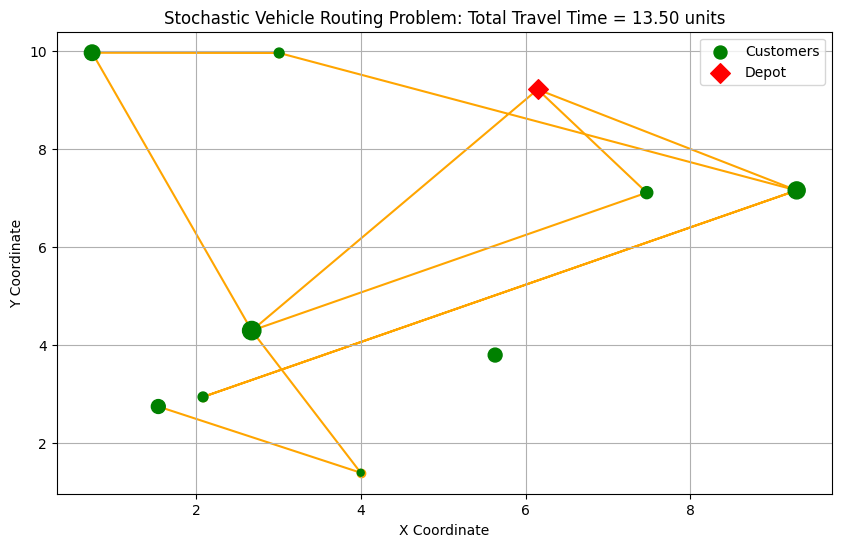

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_solution(solution, locations, demand, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.scatter(locations[:, 0], locations[:, 1], s=demand * 5, color='green', label='Customers', zorder=2)
    for route in solution:
        route_locations = np.array([locations[i] for i in route])
        plt.plot(route_locations[:, 0], route_locations[:, 1], marker='o', linestyle='-', color='orange', zorder=1)
    plt.scatter(locations[0, 0], locations[0, 1], color='red', marker='D', s=100, label='Depot', zorder=3)
    plt.legend()
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()
num_locations = 10
num_vehicles = 3
max_capacity = 100
demand = np.array([0, 20, 30, 10, 15, 25, 35, 10, 5, 20])
locations = np.random.rand(num_locations, 2) * 10
num_iterations = 100
num_ants = 10
alpha = 1.0
beta = 2.0
evaporation_rate = 0.1
svrp_instance = StochasticVRP(num_locations, num_vehicles, max_capacity, demand, travel_time_mean=15, travel_time_std=5)
best_solution, best_travel_time = svrp_instance.ant_colony_optimization(num_iterations, num_ants, alpha, beta, evaporation_rate)
plot_solution(best_solution, locations, demand, title=f'Stochastic Vehicle Routing Problem: Total Travel Time = {best_travel_time:.2f} units')

In [ ]:
!apt install libgraphviz-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 33 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgail18 amd64 2.24.33-2ubuntu2 [15.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64

In [ ]:
!pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.12-cp310-cp310-linux_x86_64.whl size=168130 sha256=b181e9a0b2171bbeb420c8d2482342b3824fa8622424f792710b1c2ed8196d3e
  Stored in directory: /root/.cache/pip/wheels/1d/ee/b5/a2f54f9e9b3951599c05dcce270ca85e472f8e6cec470e397a
Successfully built pygraphviz


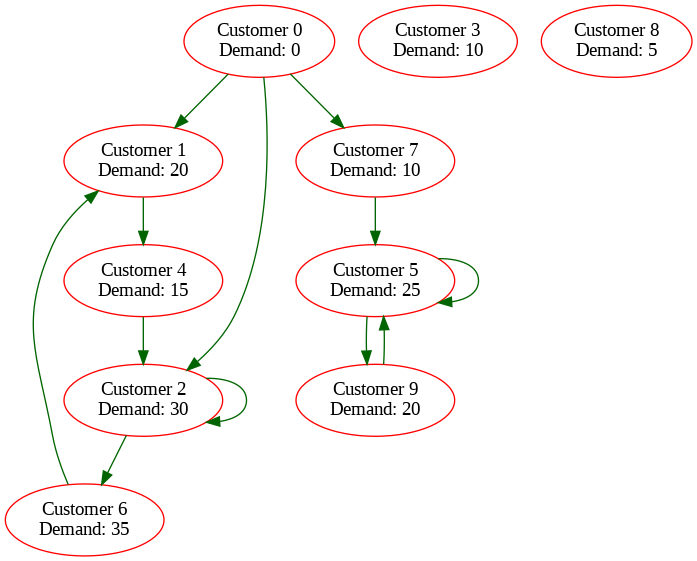

In [ ]:
import numpy as np
import random
import pygraphviz as pgv
from IPython.display import Image
class StochasticVRP:
    def __init__(self, num_locations, num_vehicles, max_capacity, demand, travel_time_mean, travel_time_std):
        self.num_locations = num_locations
        self.num_vehicles = num_vehicles
        self.max_capacity = max_capacity
        self.demand = demand
        self.travel_time_mean = travel_time_mean
        self.travel_time_std = travel_time_std
        self.distance_matrix = self.generate_distance_matrix()
    def generate_distance_matrix(self):
        distance_matrix = np.zeros((self.num_locations, self.num_locations))
        for i in range(1, self.num_locations):
            for j in range(i + 1, self.num_locations):
                travel_time = max(np.random.normal(self.travel_time_mean, self.travel_time_std), 0)
                distance_matrix[i][j] = travel_time
                distance_matrix[j][i] = travel_time
        return distance_matrix
    def ant_colony_optimization(self, num_iterations, num_ants, alpha, beta, evaporation_rate):
        best_solution = None
        best_travel_time = float('inf')
        for iteration in range(num_iterations):
            ants = [self.generate_ant_solution() for _ in range(num_ants)]
            for ant_solution in ants:
                travel_time = self.evaluate_solution(ant_solution)
                if travel_time < best_travel_time:
                    best_solution = ant_solution
                    best_travel_time = travel_time
            self.update_pheromones(ants, best_solution, evaporation_rate)
        return best_solution, best_travel_time
    def generate_ant_solution(self):
        solution = []
        remaining_capacity = [self.max_capacity] * self.num_vehicles
        for vehicle in range(self.num_vehicles):
            route = [0]
            capacity_used = 0
            while capacity_used < self.max_capacity:
                probabilities = self.calculate_probabilities(route, remaining_capacity)
                next_location = self.select_next_location(probabilities)
                if next_location == -1:
                    break
                route.append(next_location)
                remaining_capacity[vehicle] -= self.demand[next_location]
                capacity_used += self.demand[next_location]
            solution.append(route)
        return solution
    def calculate_probabilities(self, route, remaining_capacity):
        probabilities = []
        last_location = route[-1]
        for location in range(1, self.num_locations):
            if location not in route and self.demand[location] <= remaining_capacity[0]:
                distance = max(self.distance_matrix[last_location][location], 1e-6)
                probability = (1 / distance) ** beta
                probabilities.append(probability)
            else:
                probabilities.append(0)
        total_probability = sum(probabilities)
        if total_probability == 0:
            return [1 / (self.num_locations - 1)] * (self.num_locations - 1)
        probabilities = [p / total_probability for p in probabilities]
        return probabilities
    def select_next_location(self, probabilities):
        rand = random.random()
        cumulative_prob = 0
        for i, prob in enumerate(probabilities):
            cumulative_prob += prob
            if rand <= cumulative_prob:
                return i + 1
        return -1
    def evaluate_solution(self, solution):
        total_travel_time = 0
        for route in solution:
            for i in range(len(route) - 1):
                from_location = route[i]
                to_location = route[i + 1]
                total_travel_time += self.distance_matrix[from_location][to_location]
        return total_travel_time
    def update_pheromones(self, ants, best_solution, evaporation_rate):
        self.distance_matrix *= (1 - evaporation_rate)
        for route in best_solution:
            for i in range(len(route) - 1):
                from_location = route[i]
                to_location = route[i + 1]
                self.distance_matrix[from_location][to_location] += 1 / self.evaluate_solution(best_solution)
        for ant_solution in ants:
            for route in ant_solution:
                for i in range(len(route) - 1):
                    from_location = route[i]
                    to_location = route[i + 1]
                    self.distance_matrix[from_location][to_location] += 1 / self.evaluate_solution(ant_solution)
num_locations = 10
num_vehicles = 3
max_capacity = 100
demand = np.array([0, 20, 30, 10, 15, 25, 35, 10, 5, 20])
locations = np.random.rand(num_locations, 2) * 10
num_iterations = 100
num_ants = 10
alpha = 1.0
beta = 2.0
evaporation_rate = 0.1
svrp_instance = StochasticVRP(num_locations, num_vehicles, max_capacity, demand, travel_time_mean=15, travel_time_std=5)
best_solution, best_travel_time = svrp_instance.ant_colony_optimization(num_iterations, num_ants, alpha, beta, evaporation_rate)
def visualize_solution(solution, locations, demand, filename='solution.png'):
    G = pgv.AGraph(strict=True, directed=True)
    for i in range(len(locations)):
        G.add_node(i, label=f'Customer {i}\nDemand: {demand[i]}', color='red')
    for route in solution:
        for i in range(len(route) - 1):
            from_location = route[i]
            to_location = route[i + 1]
            G.add_edge(from_location, to_location, color='darkgreen')
    G.layout(prog='dot')
    G.draw(filename)
visualize_solution(best_solution, locations, demand)
Image('solution.png')

**`Vehicle Routing Problem with Pick-Up and Delivery`**

Consider a real-world example of the Vehicle Routing Problem with Pick-Up and Delivery (VRPPD) in the context of a courier or delivery service.

**`Depot`**:

`Location`: 123 Main Street, Cityville

`Coordinates`: (40.7128, -74.0060)

**`Customer A:`**

Location: 456 Elm Avenue, Suburbia

Coordinates: (40.7291, -74.0113)

Delivery Request: 5 packages


**`Customer B:`**

Location: 789 Oak Lane, Townsville

Coordinates: (40.7429, -73.9922)

Delivery Request: 3 packages

**`Customer C:`**

Location: 101 Pine Road, Villageton

Coordinates: (40.7180, -73.9962)

Delivery Request: 2 packages

**`Vehicle 1:`**

Capacity: 10 packages

Starting Location: Depot

Vehicle 2

Capacity: 8 packages

Starting Location: Depot


**`Each customer has a specified time window during which deliveries can be made`**:

Customer A: 9:00 AM - 12:00 PM

Customer B: 10:30 AM - 1:30 PM

Customer C: 1:00 PM - 4:00 PM


**`Travel Times`**:

Depot to Customer A: 15 minutes

Depot to Customer B: 20 minutes

Depot to Customer C: 10 minutes

Customer A to Customer B: 25 minutes

Customer A to Customer C: 18 minutes

Customer B to Customer C: 12 minutes


**`Objective`**:
The goal is to optimize the routes for the vehicles to minimize the total travel distance or time while ensuring that each customer's pick-up and delivery time windows are met, and the capacity of each vehicle is not exceeded.

In [ ]:
import numpy as np
depot = (40.7128, -74.0060)
customers = {
    'A': {'location': (40.7291, -74.0113), 'demand': 5, 'time_window': (9, 12)},
    'B': {'location': (40.7429, -73.9922), 'demand': 3, 'time_window': (10.5, 13.5)},
    'C': {'location': (40.7180, -73.9962), 'demand': 2, 'time_window': (13, 16)},
}
vehicles = {
    '1': {'capacity': 10, 'location': depot},
    '2': {'capacity': 8, 'location': depot},
}
travel_times = {
    ('Depot', 'A'): 15,
    ('Depot', 'B'): 20,
    ('Depot', 'C'): 10,
    ('A', 'Depot'): 15,
    ('A', 'B'): 25,
    ('A', 'C'): 18,
    ('B', 'Depot'): 20,
    ('B', 'A'): 25,
    ('B', 'C'): 12,
    ('C', 'Depot'): 10,
    ('C', 'A'): 18,
    ('C', 'B'): 12,
}
alpha = 1
beta = 2
rho = 0.5
Q = 100
num_ants = 5
num_iterations = 100
customer_index = {customer: idx for idx, customer in enumerate(['Depot'] + list(customers.keys()))}
pheromone_matrix = np.ones((len(customers) + 1, len(customers) + 1))
distance_matrix = np.zeros((len(customers) + 1, len(customers) + 1))
for i, customer_i in enumerate(['Depot'] + list(customers.keys())):
    for j, customer_j in enumerate(['Depot'] + list(customers.keys())):
        if customer_i != customer_j:
            key = (customer_i, customer_j)
            distance_matrix[i][j] = 1 / travel_times[key]
for iteration in range(num_iterations):
    ant_routes = []
    for ant in range(num_ants):
        current_solution = []
        remaining_customers = list(customers.keys())
        current_location = 'Depot'
        current_capacity = vehicles['1']['capacity']
        while remaining_customers:
            feasible_customers = [c for c in remaining_customers if customers[c]['demand'] <= current_capacity]
            if not feasible_customers:
                break
            probabilities = np.zeros(len(feasible_customers))
            for i, customer in enumerate(feasible_customers):
                probabilities[i] = (pheromone_matrix[customer_index[current_location]][customer_index[customer]]**alpha) * \
                                   (distance_matrix[customer_index[current_location]][customer_index[customer]]**beta)
            probabilities /= sum(probabilities)
            selected_customer = np.random.choice(feasible_customers, p=probabilities)
            current_solution.append((current_location, selected_customer))
            current_location = selected_customer
            current_capacity -= customers[selected_customer]['demand']
            remaining_customers.remove(selected_customer)
        current_solution.append((current_location, 'Depot'))
        ant_routes.append(current_solution)
    pheromone_matrix *= (1 - rho)
    for route in ant_routes:
        total_distance = sum(distance_matrix[customer_index[route[i][0]]][customer_index[route[i][1]]] for i in range(len(route)-1))
        pheromone_deposit = Q / total_distance
        for i in range(len(route)-1):
            pheromone_matrix[customer_index[route[i][0]]][customer_index[route[i][1]]] += pheromone_deposit
best_route = min(ant_routes, key=lambda x: sum(distance_matrix[customer_index[x[i][0]]][customer_index[x[i][1]]] for i in range(len(x)-1)))
print("Best Route:")
for step in best_route:
    print(step)

Best Route:
('Depot', 'C')
('C', 'B')
('B', 'A')
('A', 'Depot')


Best Route:
('Depot', 'C')
('C', 'B')
('B', 'A')
('A', 'Depot')


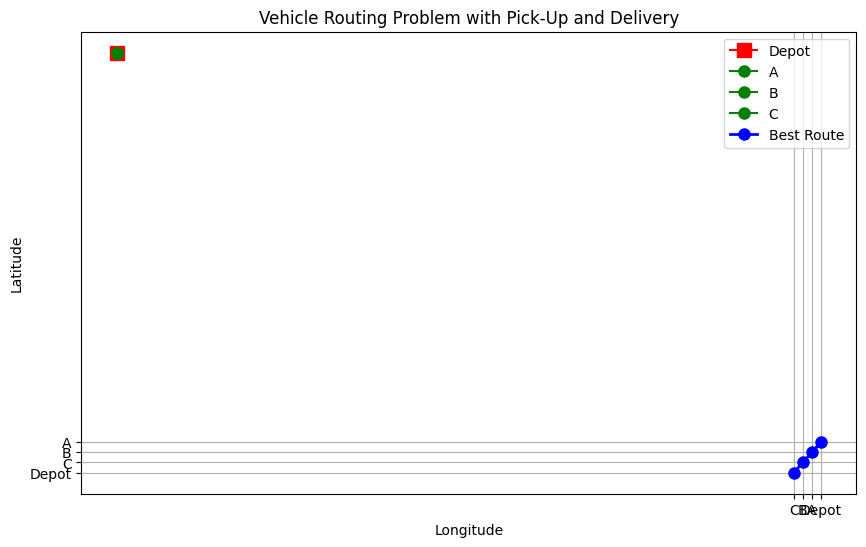

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
depot = (40.7128, -74.0060)
customers = {
    'A': {'location': (40.7291, -74.0113), 'demand': 5, 'time_window': (9, 12)},
    'B': {'location': (40.7429, -73.9922), 'demand': 3, 'time_window': (10.5, 13.5)},
    'C': {'location': (40.7180, -73.9962), 'demand': 2, 'time_window': (13, 16)},
}
vehicles = {
    '1': {'capacity': 10, 'location': depot},
    '2': {'capacity': 8, 'location': depot},
}
travel_times = {
    ('Depot', 'A'): 15,
    ('Depot', 'B'): 20,
    ('Depot', 'C'): 10,
    ('A', 'Depot'): 15,
    ('A', 'B'): 25,
    ('A', 'C'): 18,
    ('B', 'Depot'): 20,
    ('B', 'A'): 25,
    ('B', 'C'): 12,
    ('C', 'Depot'): 10,
    ('C', 'A'): 18,
    ('C', 'B'): 12,
}
alpha = 1
beta = 2
rho = 0.5
Q = 100
num_ants = 5
num_iterations = 100
customer_index = {customer: idx for idx, customer in enumerate(['Depot'] + list(customers.keys()))}
pheromone_matrix = np.ones((len(customers) + 1, len(customers) + 1))
distance_matrix = np.zeros((len(customers) + 1, len(customers) + 1))
for i, customer_i in enumerate(['Depot'] + list(customers.keys())):
    for j, customer_j in enumerate(['Depot'] + list(customers.keys())):
        if customer_i != customer_j:
            key = (customer_i, customer_j)
            distance_matrix[i][j] = 1 / travel_times[key]
for iteration in range(num_iterations):
    ant_routes = []
    for ant in range(num_ants):
        current_solution = []
        remaining_customers = list(customers.keys())
        current_location = 'Depot'
        current_capacity = vehicles['1']['capacity']
        while remaining_customers:
            feasible_customers = [c for c in remaining_customers if customers[c]['demand'] <= current_capacity]
            if not feasible_customers:
                break
            probabilities = np.zeros(len(feasible_customers))
            for i, customer in enumerate(feasible_customers):
                probabilities[i] = (pheromone_matrix[customer_index[current_location]][customer_index[customer]]**alpha) * \
                                   (distance_matrix[customer_index[current_location]][customer_index[customer]]**beta)
            probabilities /= sum(probabilities)
            selected_customer = np.random.choice(feasible_customers, p=probabilities)
            current_solution.append((current_location, selected_customer))
            current_location = selected_customer
            current_capacity -= customers[selected_customer]['demand']
            remaining_customers.remove(selected_customer)
        current_solution.append((current_location, 'Depot'))
        ant_routes.append(current_solution)
    pheromone_matrix *= (1 - rho)
    for route in ant_routes:
        total_distance = sum(distance_matrix[customer_index[route[i][0]]][customer_index[route[i][1]]] for i in range(len(route)-1))
        pheromone_deposit = Q / total_distance
        for i in range(len(route)-1):
            pheromone_matrix[customer_index[route[i][0]]][customer_index[route[i][1]]] += pheromone_deposit
best_route = min(ant_routes, key=lambda x: sum(distance_matrix[customer_index[x[i][0]]][customer_index[x[i][1]]] for i in range(len(x)-1)))
print("Best Route:")
for step in best_route:
    print(step)
plt.figure(figsize=(10, 6))
plt.plot(depot[1], depot[0], marker='s', color='red', markersize=10, label='Depot')
for customer, info in customers.items():
    plt.plot(info['location'][1], info['location'][0], marker='o', color='green', markersize=8, label=customer)
route_x = [location[1] for location in best_route]
route_y = [location[0] for location in best_route]
plt.plot(route_x, route_y, linestyle='-', color='blue', linewidth=2, marker='o', markersize=8, label='Best Route')
plt.title('Vehicle Routing Problem with Pick-Up and Delivery')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

**`Vehicle Routing Problem with Time Windows`**

In [ ]:
import numpy as np
CAPACITY = 100
ALPHA = 1.0
BETA = 2.0
Q = 1.0
customers = {
    1: {'demand': 10, 'x': 0, 'y': 0},
    2: {'demand': 20, 'x': 1, 'y': 1},
    3: {'demand': 30, 'x': 2, 'y': 2},
    4: {'demand': 40, 'x': 3, 'y': 3},
}
NUM_CUSTOMERS = len(customers)
travel_times = np.zeros((NUM_CUSTOMERS + 1, NUM_CUSTOMERS + 1))
for i in range(1, NUM_CUSTOMERS + 1):
    for j in range(1, NUM_CUSTOMERS + 1):
        if i != j:
            travel_times[i][j] = np.sqrt((customers[i]['x'] - customers[j]['x'])**2 + (customers[i]['y'] - customers[j]['y'])**2)
def calculate_time(solution):
    total_time = 0
    for i in range(len(solution) - 1):
        total_time += travel_times[solution[i]][solution[i + 1]]
    return total_time
def update_pheromones(pheromones, ant_solutions, Q):
    decay_factor = 0.5
    pheromones *= (1 - decay_factor)
    for solution in ant_solutions:
        for i in range(len(solution) - 1):
            pheromones[solution[i]][solution[i + 1]] += Q / calculate_time(solution)
    return pheromones
def ant_colony_optimization(num_ants, num_iterations):
    global pheromones
    pheromones = np.ones_like(travel_times) / 1000
    best_solution = None
    best_time = float('inf')
    for iteration in range(num_iterations):
        ant_solutions = []
        for ant in range(num_ants):
            current_solution = [0]
            current_capacity = CAPACITY
            for _ in range(NUM_CUSTOMERS):
                current_node = current_solution[-1]
                probabilities = (pheromones[current_node] ** ALPHA) * ((1 / np.maximum(travel_times[current_node], 1e-10)) ** BETA)
                probabilities[current_solution] = 0
                if np.sum(probabilities) > 0:
                    probabilities /= np.sum(probabilities)
                else:
                    probabilities = np.ones_like(probabilities) / len(probabilities)
                selected_customer = np.random.choice(range(1, NUM_CUSTOMERS + 1), p=probabilities[1:])
                current_solution.append(selected_customer)
                current_capacity -= customers[selected_customer]['demand']
                print(f"Iteration-{iteration + 1}, Ant {ant + 1}, Customer {selected_customer}, Solution = {current_solution}, Probabilities = {probabilities}")
            current_solution.append(0)
            if current_capacity >= 0:
                ant_solutions.append(current_solution)
        pheromones = update_pheromones(pheromones, ant_solutions, Q)
        for solution in ant_solutions:
            current_time = calculate_time(solution)
            if current_time < best_time:
                best_solution = solution
                best_time = current_time
        print(f"Iteration {iteration + 1}/{num_iterations}, Best Time = {best_time}")
    return best_solution, best_time
NUM_ANTS = 5
best_solution, best_time = ant_colony_optimization(NUM_ANTS, 100)
print("Final Best Solution =", best_solution)
print("Final Best Time =", best_time)

Iteration-1, Ant 1, Customer 1, Solution = [0, 1], Probabilities = [0.   0.25 0.25 0.25 0.25]
Iteration-1, Ant 1, Customer 3, Solution = [0, 1, 3], Probabilities = [0.         0.         0.73469388 0.18367347 0.08163265]
Iteration-1, Ant 1, Customer 2, Solution = [0, 1, 3, 2], Probabilities = [0.  0.  0.5 0.  0.5]
Iteration-1, Ant 1, Customer 4, Solution = [0, 1, 3, 2, 4], Probabilities = [0. 0. 0. 0. 1.]
Iteration-1, Ant 2, Customer 4, Solution = [0, 4], Probabilities = [0.   0.25 0.25 0.25 0.25]
Iteration-1, Ant 2, Customer 1, Solution = [0, 4, 1], Probabilities = [0.         0.08163265 0.18367347 0.73469388 0.        ]
Iteration-1, Ant 2, Customer 2, Solution = [0, 4, 1, 2], Probabilities = [0.  0.  0.8 0.2 0. ]
Iteration-1, Ant 2, Customer 3, Solution = [0, 4, 1, 2, 3], Probabilities = [0. 0. 0. 1. 0.]
Iteration-1, Ant 3, Customer 2, Solution = [0, 2], Probabilities = [0.   0.25 0.25 0.25 0.25]
Iteration-1, Ant 3, Customer 1, Solution = [0, 2, 1], Probabilities = [0.         0.4444

Iteration-1, Ant 1, Customer 1, Solution = [0, 1], Probabilities = [0.         0.70243902 0.17560976 0.07804878 0.04390244]
Iteration-1, Ant 1, Customer 2, Solution = [0, 1, 2], Probabilities = [0.         0.         0.73469388 0.18367347 0.08163265]
Iteration-1, Ant 1, Customer 4, Solution = [0, 1, 2, 4], Probabilities = [0.  0.  0.  0.8 0.2]
Iteration-1, Ant 1, Customer 3, Solution = [0, 1, 2, 4, 3], Probabilities = [0. 0. 0. 1. 0.]
Iteration-1, Ant 1, Customer 2, Solution = [0, 1, 2, 4, 3, 2], Probabilities = [0.2 0.2 0.2 0.2 0.2]
Iteration-1, Ant 2, Customer 2, Solution = [0, 2], Probabilities = [0.         0.70243902 0.17560976 0.07804878 0.04390244]
Iteration-1, Ant 2, Customer 4, Solution = [0, 2, 4], Probabilities = [0.         0.44444444 0.         0.44444444 0.11111111]
Iteration-1, Ant 2, Customer 3, Solution = [0, 2, 4, 3], Probabilities = [0.  0.1 0.  0.9 0. ]
Iteration-1, Ant 2, Customer 1, Solution = [0, 2, 4, 3, 1], Probabilities = [0. 1. 0. 0. 0.]
Iteration-1, Ant 2, C

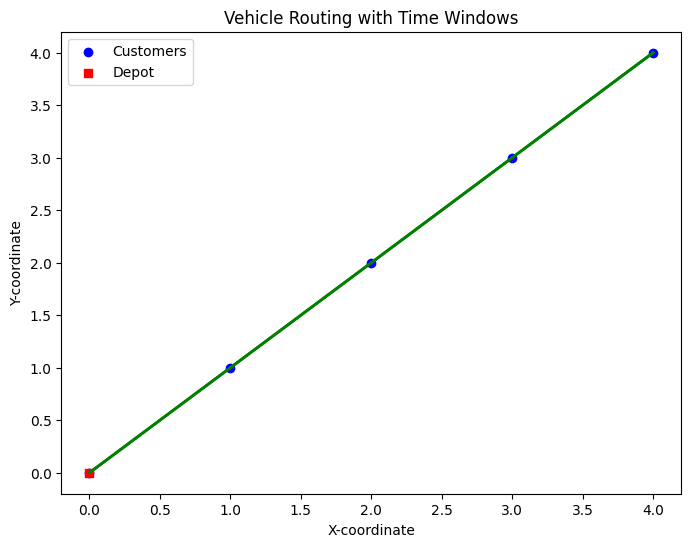

In [9]:
import numpy as np
import matplotlib.pyplot as plt
CAPACITY = 100
ALPHA = 1.0
BETA = 2.0
Q = 1.0
customers = {
    0: {'demand': 0, 'x': 0, 'y': 0},
    1: {'demand': 10, 'x': 1, 'y': 1},
    2: {'demand': 20, 'x': 2, 'y': 2},
    3: {'demand': 30, 'x': 3, 'y': 3},
    4: {'demand': 40, 'x': 4, 'y': 4},
}
NUM_CUSTOMERS = len(customers)
travel_times = np.zeros((NUM_CUSTOMERS, NUM_CUSTOMERS))
for i in range(NUM_CUSTOMERS):
    for j in range(NUM_CUSTOMERS):
        if i != j:
            travel_times[i][j] = np.sqrt((customers[i]['x'] - customers[j]['x'])**2 + (customers[i]['y'] - customers[j]['y'])**2)
def calculate_time(solution):
    total_time = 0
    for i in range(len(solution) - 1):
        total_time += travel_times[solution[i]][solution[i + 1]]
    return total_time
def update_pheromones(pheromones, ant_solutions, Q):
    decay_factor = 0.5
    pheromones *= (1 - decay_factor)
    for solution in ant_solutions:
        for i in range(len(solution) - 1):
            pheromones[solution[i]][solution[i + 1]] += Q / calculate_time(solution)
    return pheromones
def ant_colony_optimization(num_ants, num_iterations):
    global pheromones
    pheromones = np.ones_like(travel_times) / 1000
    best_solution = None
    best_time = float('inf')
    for iteration in range(num_iterations):
        ant_solutions = []
        for ant in range(num_ants):
            current_solution = [0]
            current_capacity = CAPACITY
            for _ in range(NUM_CUSTOMERS):
                current_node = current_solution[-1]
                probabilities = (pheromones[current_node] ** ALPHA) * ((1 / np.maximum(travel_times[current_node], 1e-10)) ** BETA)
                probabilities[current_solution] = 0
                if np.sum(probabilities) > 0:
                    probabilities /= np.sum(probabilities)
                else:
                    probabilities = np.ones_like(probabilities) / len(probabilities)
                selected_customer = np.random.choice(range(NUM_CUSTOMERS), p=probabilities)
                current_solution.append(selected_customer)
                current_capacity -= customers[selected_customer]['demand']
                print(f"Iteration-{iteration + 1}, Ant {ant + 1}, Customer {selected_customer}, Solution = {current_solution}, Probabilities = {probabilities}")
            current_solution.append(0)
            if current_capacity >= 0:
                ant_solutions.append(current_solution)
        pheromones = update_pheromones(pheromones, ant_solutions, Q)
        for solution in ant_solutions:
            current_time = calculate_time(solution)
            if current_time < best_time:
                best_solution = solution
                best_time = current_time
        print(f"Iteration {iteration + 1}/{num_iterations}, Best Time = {best_time}")
    return best_solution, best_time
def plot_solution(solution):
    plt.figure(figsize=(8, 6))
    plt.scatter(
        [customers[i]['x'] for i in range(NUM_CUSTOMERS)],
        [customers[i]['y'] for i in range(NUM_CUSTOMERS)],
        c='b', marker='o', label='Customers'
    )
    plt.scatter(customers[0]['x'], customers[0]['y'], c='r', marker='s', label='Depot')
    for i in range(len(solution) - 1):
        plt.plot(
            [customers[solution[i]]['x'], customers[solution[i + 1]]['x']],
            [customers[solution[i]]['y'], customers[solution[i + 1]]['y']],
            c='g', linestyle='-', linewidth=2
        )
    plt.title('Vehicle Routing with Time Windows')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.show()
NUM_ANTS = 5
best_solution, best_time = ant_colony_optimization(NUM_ANTS, 100)
print("Final Best Solution =", best_solution)
print("Final Best Time =", best_time)
plot_solution(best_solution)

**`Time Dependent Vehicle Routing Problem with Time Windows`**

In [11]:
import networkx as nx
import random
import numpy as np
num_customers = 4
num_vehicles = 3
max_capacity = 50
max_travel_time = 240
customer_locations = [(35.7804, -78.6391), (35.8423, -78.6630), (35.9042, -78.7689), (35.9277, -78.8458)]
demand = [20, 15, 30, 25]
time_windows = [(9 * 60, 10 * 60), (10 * 60 + 30, 11 * 60 + 30), (13 * 60, 14 * 60), (15 * 60, 16 * 60)]
depot_location = (35.7804, -78.6391)
depot_start_time = 8 * 60
travel_time_matrix = np.array([
    [0, 15, 30, 45, 60],
    [15, 0, 20, 35, 50],
    [30, 20, 0, 15, 30],
    [45, 35, 15, 0, 15],
    [60, 50, 30, 15, 0]
])
num_ants = 10
alpha = 1.0
beta = 2.0
evaporation_rate = 0.5
pheromone_deposit = 1.0
pheromone_levels = np.ones_like(travel_time_matrix) * 0.1
def calculate_total_distance(path):
    return sum(travel_time_matrix[path[i]][path[i + 1]] for i in range(len(path) - 1))
def is_feasible(path, current_time, demand_left, capacity_left):
    for i in range(1, len(path) - 1):
        customer_idx = path[i] - 1
        arrival_time = current_time + travel_time_matrix[path[i - 1]][path[i]]
        if not (time_windows[customer_idx][0] <= arrival_time <= time_windows[customer_idx][1]):
            return False
        demand_left -= demand[customer_idx]
        capacity_left -= demand[customer_idx]
        if demand_left < 0 or capacity_left < 0:
            return False
    return True
def update_pheromone(pheromone_levels, paths, distances):
    pheromone_levels *= (1.0 - evaporation_rate)
    for path, distance in zip(paths, distances):
        for i in range(len(path) - 1):
            pheromone_levels[path[i]][path[i + 1]] += pheromone_deposit / distance
def ant_colony_optimization():
    global pheromone_levels
    best_solution = None
    best_distance = float('inf')
    for iteration in range(100):
        ants = [[] for _ in range(num_ants)]
        distances = []
        for ant in range(num_ants):
            current_time = depot_start_time
            demand_left = max_capacity
            capacity_left = max_travel_time
            current_node = 0
            while True:
                valid_choices = [i for i in range(1, num_customers + 1) if i not in ants[ant]]
                if not valid_choices:
                    break
                probabilities = [
                    (pheromone_levels[current_node][next_node] ** alpha) * \
                    ((1 / travel_time_matrix[current_node][next_node]) ** beta)
                    for next_node in valid_choices
                ]
                probabilities /= sum(probabilities)
                next_node = np.random.choice(valid_choices, p=probabilities)
                ants[ant].append(next_node)
                current_time += travel_time_matrix[current_node][next_node]
                demand_left -= demand[next_node - 1]
                capacity_left -= travel_time_matrix[current_node][next_node]
                if not is_feasible(ants[ant], current_time, demand_left, capacity_left):
                    ants[ant].remove(next_node)
                    break
                current_node = next_node
            distance = calculate_total_distance(ants[ant])
            distances.append(distance)
            if distance < best_distance:
                best_solution = ants[ant]
                best_distance = distance
        update_pheromone(pheromone_levels, ants, distances)
    return best_solution, best_distance
best_solution, best_distance = ant_colony_optimization()
print("Best Solution =", best_solution)
print("Best Distance =", best_distance)

Best Solution = [2, 3]
Best Distance = 15


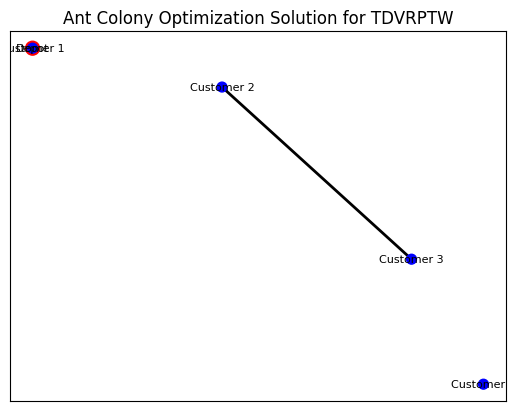

Best Solution = [3, 2]
Best Distance = 15


In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
num_customers = 4
num_vehicles = 3
max_capacity = 50
max_travel_time = 240
customer_locations = [(35.7804, -78.6391), (35.8423, -78.6630), (35.9042, -78.7689), (35.9277, -78.8458)]
demand = [20, 15, 30, 25]
time_windows = [(9 * 60, 10 * 60), (10 * 60 + 30, 11 * 60 + 30), (13 * 60, 14 * 60), (15 * 60, 16 * 60)]
depot_location = (35.7804, -78.6391)
depot_start_time = 8 * 60
travel_time_matrix = np.array([
    [0, 15, 30, 45, 60],
    [15, 0, 20, 35, 50],
    [30, 20, 0, 15, 30],
    [45, 35, 15, 0, 15],
    [60, 50, 30, 15, 0]
])

num_ants = 10
alpha = 1.0
beta = 2.0
evaporation_rate = 0.5
pheromone_deposit = 1.0
pheromone_levels = np.ones_like(travel_time_matrix) * 0.1
def calculate_total_distance(path):
    return sum(travel_time_matrix[path[i]][path[i + 1]] for i in range(len(path) - 1))
def is_feasible(path, current_time, demand_left, capacity_left):
    for i in range(1, len(path) - 1):
        customer_idx = path[i] - 1
        arrival_time = current_time + travel_time_matrix[path[i - 1]][path[i]]
        if not (time_windows[customer_idx][0] <= arrival_time <= time_windows[customer_idx][1]):
            return False
        demand_left -= demand[customer_idx]
        capacity_left -= demand[customer_idx]
        if demand_left < 0 or capacity_left < 0:
            return False
    return True
def update_pheromone(pheromone_levels, paths, distances):
    pheromone_levels *= (1.0 - evaporation_rate)
    for path, distance in zip(paths, distances):
        for i in range(len(path) - 1):
            pheromone_levels[path[i]][path[i + 1]] += pheromone_deposit / distance
def ant_colony_optimization():
    global pheromone_levels
    best_solution = None
    best_distance = float('inf')
    for iteration in range(100):
        ants = [[] for _ in range(num_ants)]
        distances = []
        for ant in range(num_ants):
            current_time = depot_start_time
            demand_left = max_capacity
            capacity_left = max_travel_time
            current_node = 0
            while True:
                valid_choices = [i for i in range(1, num_customers + 1) if i not in ants[ant]]
                if not valid_choices:
                    break
                probabilities = [
                    (pheromone_levels[current_node][next_node] ** alpha) * \
                    ((1 / travel_time_matrix[current_node][next_node]) ** beta)
                    for next_node in valid_choices
                ]
                probabilities /= sum(probabilities)
                next_node = np.random.choice(valid_choices, p=probabilities)
                ants[ant].append(next_node)
                current_time += travel_time_matrix[current_node][next_node]
                demand_left -= demand[next_node - 1]
                capacity_left -= travel_time_matrix[current_node][next_node]
                if not is_feasible(ants[ant], current_time, demand_left, capacity_left):
                    ants[ant].remove(next_node)
                    break
                current_node = next_node
            distance = calculate_total_distance(ants[ant])
            distances.append(distance)
            if distance < best_distance:
                best_solution = ants[ant]
                best_distance = distance
        update_pheromone(pheromone_levels, ants, distances)
    return best_solution, best_distance
def visualize_solution(solution, depot_location, customer_locations):
    G = nx.Graph()
    G.add_node('Depot', pos=depot_location, color='red', size=100)
    for i, customer_loc in enumerate(customer_locations):
        G.add_node(f'Customer {i + 1}', pos=customer_loc, color='blue', size=50)
    for i in range(len(solution) - 1):
        G.add_edge(f'Customer {solution[i]}', f'Customer {solution[i + 1]}', weight=1)
    pos = nx.get_node_attributes(G, 'pos')
    node_colors = [G.nodes[node]['color'] for node in G.nodes]
    node_sizes = [G.nodes[node]['size'] for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges, width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title("Ant Colony Optimization Solution for TDVRPTW")
    plt.show()
best_solution, best_distance = ant_colony_optimization()
visualize_solution(best_solution, depot_location, customer_locations)
print("Best Solution =", best_solution)
print("Best Distance =", best_distance)

In [15]:
!apt install libgraphviz-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 33 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgail18 amd64 2.24.33-2ubuntu2 [15.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64

In [16]:
!pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.12-cp310-cp310-linux_x86_64.whl size=168136 sha256=85e54a9ce2b1c1cbeeaa5a9c04b9289b61a419c90a47c71f17dc162f0e78211f
  Stored in directory: /root/.cache/pip/wheels/1d/ee/b5/a2f54f9e9b3951599c05dcce270ca85e472f8e6cec470e397a
Successfully built pygraphviz


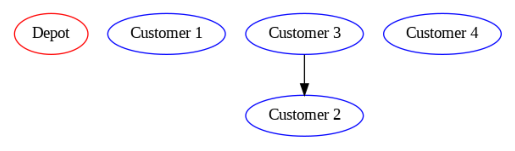

Best Solution = [3, 2]
Best Distance = 15


In [19]:
import pygraphviz as pgv
import random
import numpy as np
import matplotlib.pyplot as plt
num_customers = 4
num_vehicles = 3
max_capacity = 50
max_travel_time = 240
customer_locations = [(35.7804, -78.6391), (35.8423, -78.6630), (35.9042, -78.7689), (35.9277, -78.8458)]
demand = [20, 15, 30, 25]
time_windows = [(9 * 60, 10 * 60), (10 * 60 + 30, 11 * 60 + 30), (13 * 60, 14 * 60), (15 * 60, 16 * 60)]
depot_location = (35.7804, -78.6391)
depot_start_time = 8 * 60
travel_time_matrix = np.array([
    [0, 15, 30, 45, 60],
    [15, 0, 20, 35, 50],
    [30, 20, 0, 15, 30],
    [45, 35, 15, 0, 15],
    [60, 50, 30, 15, 0]
])
num_ants = 10
alpha = 1.0
beta = 2.0
evaporation_rate = 0.5
pheromone_deposit = 1.0
pheromone_levels = np.ones_like(travel_time_matrix) * 0.1
def calculate_total_distance(path):
    return sum(travel_time_matrix[path[i]][path[i + 1]] for i in range(len(path) - 1))
def is_feasible(path, current_time, demand_left, capacity_left):
    for i in range(1, len(path) - 1):
        customer_idx = path[i] - 1
        arrival_time = current_time + travel_time_matrix[path[i - 1]][path[i]]
        if not (time_windows[customer_idx][0] <= arrival_time <= time_windows[customer_idx][1]):
            return False
        demand_left -= demand[customer_idx]
        capacity_left -= demand[customer_idx]
        if demand_left < 0 or capacity_left < 0:
            return False
    return True
def update_pheromone(pheromone_levels, paths, distances):
    pheromone_levels *= (1.0 - evaporation_rate)
    for path, distance in zip(paths, distances):
        for i in range(len(path) - 1):
            pheromone_levels[path[i]][path[i + 1]] += pheromone_deposit / distance
def ant_colony_optimization():
    global pheromone_levels
    best_solution = None
    best_distance = float('inf')
    for iteration in range(100):
        ants = [[] for _ in range(num_ants)]
        distances = []
        for ant in range(num_ants):
            current_time = depot_start_time
            demand_left = max_capacity
            capacity_left = max_travel_time
            current_node = 0
            while True:
                valid_choices = [i for i in range(1, num_customers + 1) if i not in ants[ant]]
                if not valid_choices:
                    break
                probabilities = [
                    (pheromone_levels[current_node][next_node] ** alpha) * \
                    ((1 / travel_time_matrix[current_node][next_node]) ** beta)
                    for next_node in valid_choices
                ]
                probabilities /= sum(probabilities)
                next_node = np.random.choice(valid_choices, p=probabilities)
                ants[ant].append(next_node)
                current_time += travel_time_matrix[current_node][next_node]
                demand_left -= demand[next_node - 1]
                capacity_left -= travel_time_matrix[current_node][next_node]
                if not is_feasible(ants[ant], current_time, demand_left, capacity_left):
                    ants[ant].remove(next_node)
                    break
                current_node = next_node
            distance = calculate_total_distance(ants[ant])
            distances.append(distance)
            if distance < best_distance:
                best_solution = ants[ant]
                best_distance = distance
        update_pheromone(pheromone_levels, ants, distances)
    return best_solution, best_distance
def visualize_solution_pygraphviz(solution, depot_location, customer_locations):
    G = pgv.AGraph(directed=True)
    G.add_node('Depot', pos=depot_location, color='red', size=1.0)
    for i, customer_loc in enumerate(customer_locations):
        G.add_node(f'Customer {i + 1}', pos=customer_loc, color='blue', size=0.5)
    for i in range(len(solution) - 1):
        G.add_edge(f'Customer {solution[i]}', f'Customer {solution[i + 1]}', weight=1)
    G.layout(prog='dot')
    G.draw('aco_solution.png')
    img = plt.imread('aco_solution.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
best_solution, best_distance = ant_colony_optimization()
visualize_solution_pygraphviz(best_solution, depot_location, customer_locations)
print("Best Solution =", best_solution)
print("Best Distance =", best_distance)

**`Vehicle Routing Problem with Time Windows & Multiple Service Workers`**

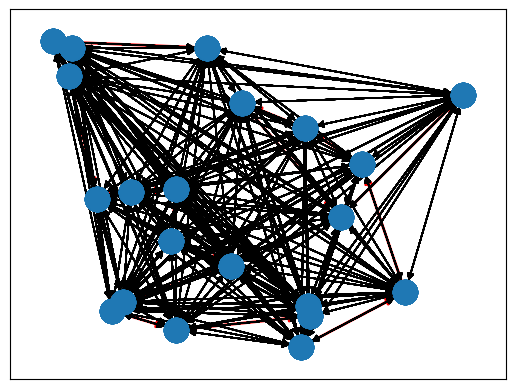

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
def generate_vrptw_instance(num_nodes, num_vehicles, max_capacity, time_window):
    np.random.seed(42)
    locations = np.random.rand(num_nodes, 2)
    demands = np.random.randint(1, 10, num_nodes)
    capacities = np.full(num_vehicles, max_capacity)
    time_windows = np.random.randint(time_window[0], time_window[1], (num_nodes, 2))
    return locations, demands, capacities, time_windows
def calculate_distance(node1, node2):
    return np.linalg.norm(node1 - node2)
def create_graph(locations, demands):
    num_nodes = len(locations)
    G = nx.DiGraph()
    for i in range(num_nodes):
        G.add_node(i, pos=locations[i], demand=demands[i])
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            distance = calculate_distance(locations[i], locations[j])
            G.add_edge(i, j, weight=distance)
            G.add_edge(j, i, weight=distance)
    return G
def ant_colony_vrptw(graph, num_ants, alpha, beta, evaporation_rate, num_iterations):
    pheromones = np.ones((graph.number_of_nodes(), graph.number_of_nodes()), dtype=float)
    best_solution = None
    best_cost = float('inf')
    for iteration in range(num_iterations):
        solutions = []
        for ant in range(num_ants):
            solution = construct_solution(graph, pheromones, alpha, beta)
            solutions.append((solution, calculate_solution_cost(graph, solution)))
        update_pheromones(pheromones, solutions, evaporation_rate)
        for solution, cost in solutions:
            if cost < best_cost:
                best_solution = solution
                best_cost = cost
    return best_solution
def construct_solution(graph, pheromones, alpha, beta):
    num_nodes = graph.number_of_nodes()
    num_vehicles = graph.number_of_nodes() - 1
    solution = []
    unvisited_nodes = set(range(1, num_nodes))
    for vehicle in range(num_vehicles):
        current_node = 0
        route = [current_node]
        while unvisited_nodes:
            probabilities = calculate_probabilities(graph, pheromones, current_node, unvisited_nodes, alpha, beta)
            next_node = np.random.choice(list(unvisited_nodes), p=probabilities)
            route.append(next_node)
            unvisited_nodes.remove(next_node)
            current_node = next_node
        solution.append(route)
    return solution
def calculate_probabilities(graph, pheromones, current_node, unvisited_nodes, alpha, beta):
    probabilities = []
    total_prob = 0.0
    for neighbor in unvisited_nodes:
        pheromone = pheromones[current_node, neighbor]
        distance = graph.edges[current_node, neighbor]['weight']
        heuristic_info = 1.0 / distance if distance > 0 else 0.0
        probability = (pheromone**alpha) * (heuristic_info**beta)
        probabilities.append(probability)
        total_prob += probability
    probabilities = [prob / total_prob for prob in probabilities]
    return probabilities
def calculate_solution_cost(graph, solution):
    total_cost = 0.0
    for route in solution:
        route_cost = 0.0
        for i in range(len(route) - 1):
            route_cost += graph.edges[route[i], route[i + 1]]['weight']
        total_cost += route_cost
    return total_cost
def update_pheromones(pheromones, solutions, evaporation_rate):
    pheromones *= (1.0 - evaporation_rate)
    for solution, cost in solutions:
        for i in range(len(solution) - 1):
            pheromones[solution[i], solution[i + 1]] += 1.0 / cost
def visualize_solution(graph, solution):
    pos = nx.get_node_attributes(graph, 'pos')
    for i, route in enumerate(solution):
        route_edges = [(route[j], route[j + 1]) for j in range(len(route) - 1)]
        nx.draw_networkx_nodes(graph, pos)
        nx.draw_networkx_edges(graph, pos)
        nx.draw_networkx_edges(graph, pos, edgelist=route_edges, edge_color='r', width=2)
    plt.show()
num_nodes = 20
num_vehicles = 4
max_capacity = 20
time_window = (0, 100)
locations, demands, capacities, time_windows = generate_vrptw_instance(num_nodes + 1, num_vehicles, max_capacity, time_window)
graph = create_graph(locations, demands)
solution = ant_colony_vrptw(graph, num_ants=10, alpha=1.0, beta=2.0, evaporation_rate=0.5, num_iterations=100)
visualize_solution(graph, solution)